# Dataset

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Instantiate the Kaggle API
api = KaggleApi()

# Download the dataset
api.dataset_download_files('datasnaek/chess', path='./data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/datasnaek/chess


In [2]:
import pandas as pd 

data = pd.read_csv('./data/games.csv')
data.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


# Board Visualisation

## Static Board

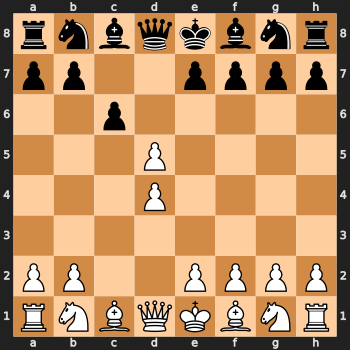

In [3]:
import pandas as pd
import chess
import chess.svg
from IPython.display import SVG

# Step 1: Load the dataset
df = data

# Step 2: Extract the first row
first_row = df.iloc[0]

# Step 3: Extract the moves and opening_ply
moves = first_row['moves']  # Assuming the column with moves is named 'moves'
opening_ply = first_row['opening_ply']  # Assuming the column with opening_ply is named 'opening_ply'

# Step 4: Parse the moves up to opening_ply
move_list = moves.split()[:opening_ply]

# Step 5: Create a chess board and apply the moves
board = chess.Board()
for move in move_list:
    board.push_san(move)

# Step 6: Visualize the board with title
board_svg = chess.svg.board(board, size=350)
SVG(board_svg)

## Dynamic Board

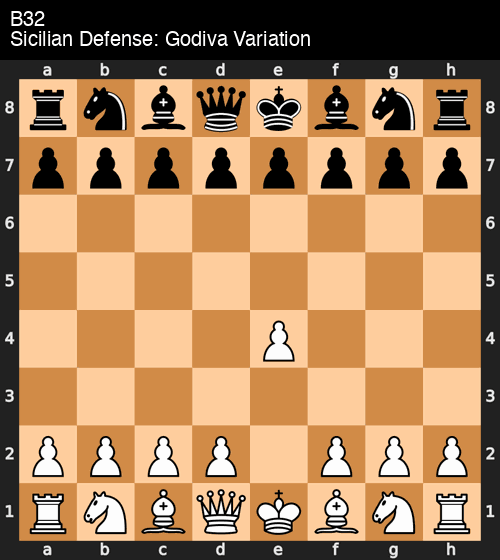

In [4]:
import pyvips
import io
from PIL import Image, ImageDraw, ImageFont
import chess
import chess.svg
from IPython.display import display, Image as IPImage
import random

# Step 1: Load the dataset
df = data

# Step 2: Extract the first row
# Choose a random row from the dataframe
random_row = df.sample(n=1)

# Extract the first row from the random row
row = random_row.iloc[0]

# Step 3: Extract the moves, opening_ply, opening_eco, and opening_name
moves = row['moves']
opening_ply = row['opening_ply']
opening_eco = row['opening_eco']
opening_name = row['opening_name']

# Step 4: Parse the moves up to opening_ply
move_list = moves.split()[:opening_ply]

# Step 7: Initialize an empty list to store frames
frames = []

# Step 8: Create a chess board
board = chess.Board()

# Step 9: Iterate through the moves and save each board state as an image
for move in move_list:
    # Make the move on the board
    board.push_san(move)
    
    # Generate SVG for the current board state with a smaller size
    board_svg = chess.svg.board(board, size=350)
    
    # Convert the SVG to PNG using pyvips
    svg_bytes = bytes(board_svg, 'utf-8')
    image = pyvips.Image.svgload_buffer(svg_bytes, dpi=200)
    
    # Convert the pyvips image to PIL Image format (necessary for gif creation)
    pil_image = Image.frombytes('RGBA', (image.width, image.height), image.write_to_memory(), 'raw', 'RGBA', 0, 1)
    
    # Resize the image to make it smaller
    pil_image = pil_image.resize((500, 500))  # Adjust size as needed
    
    # Step 10: Create a new image with space above for the text
    space = 60
    new_image = Image.new('RGBA', (500, 500+space), (0, 0, 0, 255))  # Adjust height for text space (50 pixels)
    
    # Paste the chessboard image onto the new image, shifted down by 50 pixels
    new_image.paste(pil_image, (0, space))
    
    # Step 11: Add text (opening_eco and opening_name) to the image
    draw = ImageDraw.Draw(new_image)
    
    # Define font with larger size (using a system font or custom TTF file)
    try:
        font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Helvetica.ttc", size=20)  # Increase size to 24 or adjust as needed
    except IOError:
        # Fallback to default font if arial.ttf is not found
        font = ImageFont.load_default()
    
    # Define text position and color
    text_position = (10, 10)  # Adjust position for the text at the top
    text_color = (255, 255, 255)  # White text
    text_content = f"{opening_eco}\n{opening_name}"
    
    # Add the text to the image
    draw.text(text_position, text_content, font=font, fill=text_color)
    
    # Append the new image with text and chessboard to frames list
    frames.append(new_image)

# Step 12: Create a GIF from the frames
gif_path = 'visuals/chess_moves.gif'
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=1000, loop=0)

# Step 13: Display the GIF in the notebook
display(IPImage(filename=gif_path))